# Graph Coloring Example aka. Frequency Assignment Example

Lucerne University of Applied Sciences and Arts - School of Information Technology

To send information from one cell to another in a cellular network, the transmission ranges of antennas must overlap.
Neighboring antennas must use different frequencies in order to avoid interference problems. There is only a very
limited number of frequencies available. Assign frequencies to antennas such that not two neighboring antennas use the same frequency. We model this as graph coloring problem. Hence, we subsequently refer to frequencies as colors. 
 
@author: Tobias Mérinat and Marc Pouly

Imports

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

from ortools.sat.python import cp_model

%matplotlib inline

## Example from the lecture

Undirected graph as list of edges

In [3]:
graph = ((4, 1), (1, 0), (4, 0), (1, 3), (3, 0), (3, 2))

Graph size as number of nodes

In [4]:
size = len(set(sum(graph, ())))  # or use itertools.chain.from_iterable()

print(f"Graph has {size} different nodes.")

Graph has 5 different nodes.


Color names (frequencies) for pretty-printing

In [5]:
names = ("red", "blue", "green", "yellow", "orange", "black", "white", "purple")

Maximum number of allowed colors

In [6]:
max_colors = 3

## Model 1: Constraint Problem with 1D Array of Integers

In [9]:
model1 = cp_model.CpModel()

# Model with a single array: color[n] = j <=> node n takes color j
color = [model1.NewIntVar(0, max_colors - 1, str(i)) for i in range(size)]
print(color)

# No neighboring nodes may have the same color
for edge in graph:
    print(edge)
    model1.Add(color[edge[0]] != color[edge[1]])

# Elementary symmetry breaking: First node takes first color
model1.Add(color[0] == 0)

[0(0..2), 1(0..2), 2(0..2), 3(0..2), 4(0..2)]
(4, 1)
(1, 0)
(4, 0)
(1, 3)
(3, 0)
(3, 2)


In [10]:
class MyArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    
    def __init__(self, variables, color_names):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__color_names = color_names
        self.__variables = variables
        self.__solutions = []
        
    def on_solution_callback(self):
        self.__solutions.append([self.Value(node) for node in self.__variables])
        # for node in self.__variables:
        # print(f"Node #{node} has color {self.__color_names[self.Value(node)]}")
        # print("\n")
        
    def get_all_solutions(self):
        return self.__solutions

In [11]:
solver = cp_model.CpSolver()

callback = MyArraySolutionPrinter(color, names)
#callback = cp_model.VarArraySolutionPrinter(color)
status = solver.SearchForAllSolutions(model1, callback)
print(f"Solver status: {status}")

Solver status: 4


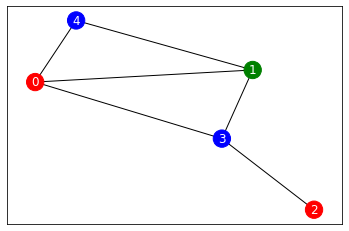

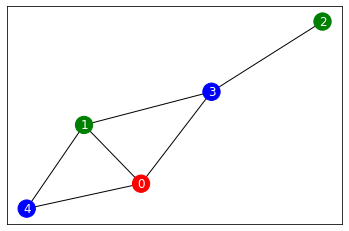

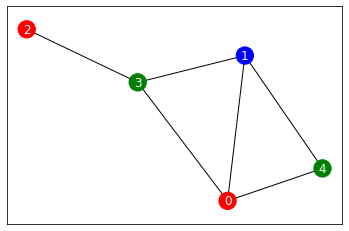

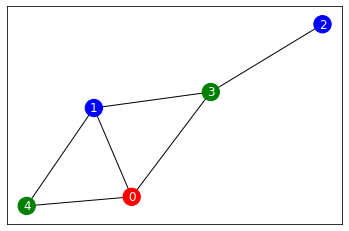

In [12]:
def draw(names, graph, solution):
    G = nx.Graph()
    G.add_nodes_from(range(size))
    G.add_edges_from(graph)
    nx.draw_networkx(G, font_color="white", node_color=[names[i] for i in solution])
    plt.show()

for sol in callback.get_all_solutions():
    draw(names, graph, sol) 

## Model 2: Constraint Problem with 2D Array of Booleans

In [16]:
model2 = cp_model.CpModel()

# 2D Board of binary variables: row indices stand for graph nodes; column indices for colors
board = [[model2.NewBoolVar(f"({_i},{_j})") for _j in range(max_colors)] for _i in range(size)]
print(board)

# Each node takes exactly one color
for n in range(size):
    model2.Add(sum([board[n][c] for c in range(max_colors)]) == 1)

# No neighboring nodes may have the same color
for edge in graph:
    # One edge identifies two rows in board that must not be 1 at the same time.
    for c in range(max_colors):
        model2.Add(board[edge[0]][c] + board[edge[1]][c] < 2)

# Elementary symmetry breaking: First node takes first color
model2.Add(board[0][0] == 1)

[[(0,0)(0..1), (0,1)(0..1), (0,2)(0..1)], [(1,0)(0..1), (1,1)(0..1), (1,2)(0..1)], [(2,0)(0..1), (2,1)(0..1), (2,2)(0..1)], [(3,0)(0..1), (3,1)(0..1), (3,2)(0..1)], [(4,0)(0..1), (4,1)(0..1), (4,2)(0..1)]]


In [17]:
class BoardSolutionPrinter(cp_model.CpSolverSolutionCallback):
    
    def __init__(self, variables, color_names):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__color_names = color_names
        self.__variables = variables
        self.__solutions = []
        
    def on_solution_callback(self):
        solution = []
        for n in range(len(board)):
            for c in range(len(board[0])):
                if self.Value(board[n][c]) > 0:
                    solution.append(c)
                    #print(f"Node {n} takes color {self.__color_names[c]}")
        #print("")
        self.__solutions.append(solution)
        
    def get_all_solutions(self):
        return self.__solutions

Solver status: 4


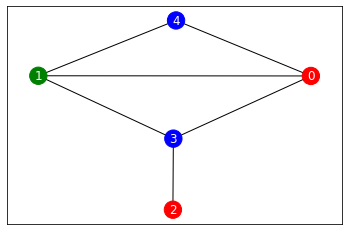

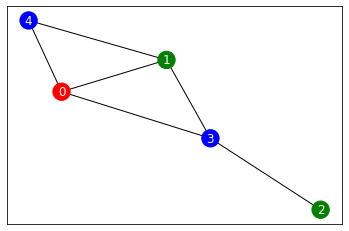

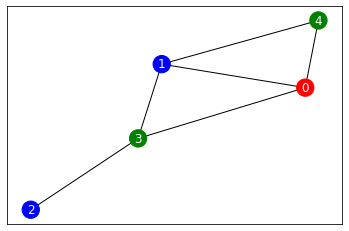

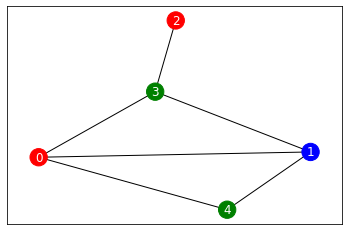

In [18]:
solver = cp_model.CpSolver()

callback2 = BoardSolutionPrinter(board, names)
status = solver.SearchForAllSolutions(model2, callback2)
print(f"Solver status: {status}")

for sol in callback2.get_all_solutions():
    draw(names, graph, sol) 

## Model 3: Optimization Problem with 2D Array of Booleans

In [39]:
model3 = cp_model.CpModel()
graph = ((4, 1), (1, 0), (4, 0), (1, 3), (3, 0), (3, 2))

# 2D Board of binary variables: row indices stand for graph nodes; column indices for colors
# Note that we allow as many colors as nodes to always ensure a solution
num_colors = size
board = [[model3.NewBoolVar(f"({_i},{_j})") for _j in range(num_colors)] for _i in range(size)]
print(board)

# Each node takes exactly one color
for n in range(size):
    model3.Add(sum([board[n][c] for c in range(num_colors)]) == 1)

# No neighboring nodes may have the same color
for edge in graph:
    # One edge identifies two rows in board that must not be 1 at the same time.
    for c in range(num_colors):
        model3.Add(board[edge[0]][c] + board[edge[1]][c] < 2)

# Elementary symmetry breaking: First node takes first color
model3.Add(board[0][0] == 1)

# Has a color been used at all?
used = [model3.NewBoolVar(str(c)) for c in range(num_colors)]

# Channel constraints
for c in range(num_colors):
    count = sum([board[n][c] for n in range(size)])
    # When count > 0 this color has been used
    model3.Add(count > 0).OnlyEnforceIf(used[c])
    # When count == 0 this color has not been used
    model3.Add(count == 0).OnlyEnforceIf(used[c].Not())

# Objective function: minimize number of used variables
model3.Minimize(sum(used))

[[(0,0)(0..1), (0,1)(0..1), (0,2)(0..1), (0,3)(0..1), (0,4)(0..1)], [(1,0)(0..1), (1,1)(0..1), (1,2)(0..1), (1,3)(0..1), (1,4)(0..1)], [(2,0)(0..1), (2,1)(0..1), (2,2)(0..1), (2,3)(0..1), (2,4)(0..1)], [(3,0)(0..1), (3,1)(0..1), (3,2)(0..1), (3,3)(0..1), (3,4)(0..1)], [(4,0)(0..1), (4,1)(0..1), (4,2)(0..1), (4,3)(0..1), (4,4)(0..1)]]


Optimal objective value: 3.0
Node 0 takes color red
Node 1 takes color green
Node 2 takes color red
Node 3 takes color blue
Node 4 takes color blue


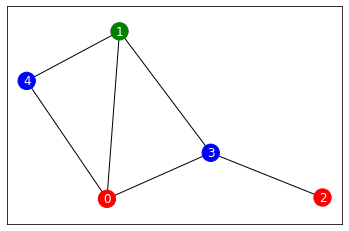

In [40]:
# Search for all solutions is only defined on satisfiability problems
status = solver.Solve(model3)

if status == cp_model.OPTIMAL:
    print(f"Optimal objective value: {solver.ObjectiveValue()}")
    result = []
    for n in range(len(board)):
        for c in range(len(board[0])):
            if solver.Value(board[n][c]) > 0:
                result.append(c)
                print(f"Node {n} takes color {names[c]}")
    draw(names, graph, result) 
    
elif status == cp_model.INFEASIBLE:
    print("The model is over-constrained.")